# MaskG

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
from tensorflow.python.keras import layers
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# from tensorflow.python.keras.layers import Dense

## layer

In [19]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(name='scale',
                                 shape=input_shape[-1:],
                                 initializer=tf.random_normal_initializer(1., 0.02),
                                 trainable=True)

    self.offset = self.add_weight(name='offset',
                                  shape=input_shape[-1:],
                                  initializer='zeros',
                                  trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


class SE_Block(tf.keras.layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SE_Block, self).__init__()
        self.channels = channels
        self.reduction_ratio = reduction_ratio
        self.initializer = tf.random_normal_initializer(0., 0.02)

    def build(self, input_shape):
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.conv1 = tf.keras.layers.Conv2D(filters=self.channels // self.reduction_ratio,
                                            kernel_size=1,
                                            activation='relu',
                                            kernel_initializer=self.initializer)

        self.conv2 = tf.keras.layers.Conv2D(filters=self.channels,
                                            kernel_size=1,
                                            activation='sigmoid',
                                            kernel_initializer=self.initializer)

    def call(self, inputs):
        batch_size = inputs.shape[0]
        pooled_inputs = self.global_pooling(inputs)
        reshaped_inputs = tf.reshape(pooled_inputs, [batch_size, 1, 1,-1])
        conv_output = self.conv1(reshaped_inputs)
        conv_output = self.conv2(conv_output)
        return tf.math.multiply(inputs, conv_output)


class ASPP(tf.keras.layers.Layer):
    def __init__(self, channels, rates=[2, 4, 8, 16]):
        super(ASPP, self).__init__()
        self.channels = channels
        self.rates = rates

    def build(self, input_shape):
        self.conv1x1 =  conv_block(self.channels, size=1, strides=1,
                                   norm_type='instance', activation='lrelu')

        self.conv3x3_1 = conv_block(self.channels, size=3, strides=1,
                                    dilation_rate=self.rates[0],
                                    norm_type='instance', activation='lrelu')

        self.conv3x3_2 = conv_block(self.channels, size=3, strides=1,
                                    dilation_rate=self.rates[1],
                                    norm_type='instance', activation='lrelu')

        self.conv3x3_3 = conv_block(self.channels, size=3, strides=1,
                                    dilation_rate=self.rates[2],
                                    norm_type='instance', activation='lrelu')

        # self.conv3x3_4 = conv_block(self.channels, size=3, strides=1, dilation_rate=self.rates[3], norm_type='instance', activation='lrelu')

        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.conv1x1_pool = conv_block(self.channels, size=1, strides=1,
                                       norm_type='instance', activation='lrelu')

        self.concat = tf.keras.layers.Concatenate()
        self.conv1x1_concat = conv_block(self.channels, size=1, strides=1,
                                         norm_type='instance', activation='lrelu')

    def call(self, inputs):
        batch_size = inputs.shape[0]
        x1 = self.conv1x1(inputs)
        x2 = self.conv3x3_1(inputs)
        x3 = self.conv3x3_2(inputs)
        x4 = self.conv3x3_3(inputs)
        # x5 = self.conv3x3_4(inputs)

        x5 = self.global_pooling(inputs)
        x5 = tf.reshape(x5, [batch_size, 1, 1, -1])
        x5 = self.conv1x1_pool(x5)
        x5 = tf.image.resize(x5, (inputs.shape[1], inputs.shape[2]))

        x = self.concat([x1, x2, x3, x4, x5])
        x = self.conv1x1_concat(x)
        return x

In [16]:
def conv_block(filters, size=3, strides=2, dilation_rate=1, norm_type=None, activation='lrelu', downsample=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    sequential = tf.keras.Sequential()
    if downsample:
        sequential.add(
            tf.keras.layers.Conv2D(filters, size, strides=strides,
                                   padding='same', dilation_rate=dilation_rate,
                                   kernel_initializer=initializer, use_bias=False))
    else:
        sequential.add(
            tf.keras.layers.Conv2DTranspose(filters, size, strides=strides,
                                            padding='same', kernel_initializer=initializer,
                                            use_bias=False))
        if norm_type is not None:
            if norm_type == 'instance':
                sequential.add(InstanceNormalization())
            elif norm_type == 'batch':
                sequential.add(tf.keras.layers.BatchNormalization())

        if activation == 'lrelu':
            sequential.add(tf.keras.layers.LeakyReLU())
        elif activation == 'relu':
            sequential.add(tf.keras.layers.ReLU())
    return sequential

## noise processing

In [8]:
def noise_processing(generate_image):
    """
    Mask Generator를 통해 나온 Binary 이미지에 Noise 제거
    Args:
      generate_image : model를 통해 생성된 이미지
    Return:
      processe가 된 인물 이미지
    """
    generate_image = generate_image.numpy()
    batch, height, width  = generate_image.shape[0], generate_image.shape[1], generate_image.shape[2]
    generate_image = generate_image[:, :, :, 0]
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    for i in range(batch):
        generate_image[i]= cv2.erode(generate_image[i], k)             #  mask Morphology 연산 전처리
        generate_image[i] = cv2.dilate(generate_image[i], k)
    generate_image = np.where(generate_image >= -0.9, 1, -1)
    generate_image = tf.convert_to_tensor(generate_image, dtype=tf.float32)
    generate_image = tf.reshape(generate_image, [batch, height, width , 1])
    return generate_image

def face_training_visualization(model, test_input, mask_map, tar, epoch, step, save_dir='./face32_training'):
    """
    fece model training visualization
    Args:
        model : Mask Generate model
        test_input : input image
        mask_map : Mask Generate model out
        tar : ground truth image
        epoch, step : training epoch, step
    """

    plt.ion()
    figure, ax = plt.subplots(figsize=(8,8))

    if not os.path.exists(save_dir):
      os.mkdir(save_dir)

    prediction = model([test_input, mask_map], training=False)
    display_list = [test_input[0], tar[0], prediction[0], mask_map[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image', 'Predicted mask']

    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(save_dir+"/epoch_{epoch}_step_{step}.png".format(epoch=epoch, step=step))
    plt.show()

    figure.canvas.draw()
    figure.canvas.flush_events()

## Prediction

In [12]:
class Load_Model():
    def __init__(self, mask_model, face_model, mask_checkpoint_dir, face_checkpoint_dir):
        self.mask_model = mask_model
        self.face_model = face_model

        self.mask_checkpoint_dir = mask_checkpoint_dir
        self.face_checkpoint_dir = face_checkpoint_dir

        self.mask_checkpoint = tf.train.Checkpoint(generator=self.mask_model)
        self.face_checkpoint = tf.train.Checkpoint(generator=self.face_model)

        self.mask_checkpoint.restore(tf.train.latest_checkpoint(self.mask_checkpoint_dir))
        self.face_checkpoint.restore(tf.train.latest_checkpoint(self.face_checkpoint_dir))

    def predict(self, img_path, img_size=256):
        img = plt.imread(img_path)
        if img_path.endswith('.jpg') or img_path.endswith('.PNG'):
            img = img * 255.0
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = tf.image.resize(img, [img_size, img_size],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        img = tf.reshape(img, [1, img_size, img_size, 3])
        img = tf.cast(img, tf.float32)
        img =  (img / 127.5) - 1

        mask = self.mask_model(img, training=False)
        mask = noise_processing(mask)
        pred = self.face_model([img, mask], training=False)

        plt.figure(figsize=(8,8))
        plt.title('Prediction Image')
        plt.imshow(pred[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

## Mask G and Face G

In [82]:
class Mask_G(tf.keras.Model):
    def __init__(self, filters=32, block_num=5):
        super(Mask_G, self).__init__()
        self.filters = filters
        self.block_num = block_num
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.encoders = []
        self.decoders = []

    def build(self, input_shape):
        # Encoder layers
        for i in range(self.block_num):
            norm_type = 'instance' if i != 0 else None
            downsample_block = conv_block(self.filters, size=3, strides=2,
                                          norm_type=norm_type, activation='lrelu')

            self.encoders.append(downsample_block)

            self.filters = self.filters*2 if i < 4 else self.filters

        self.encoders.append(conv_block(self.filters, size=3, strides=2,
                                        norm_type='instance', activation='lrelu'))
        # Dencoder layers
        for i in range(self.block_num):
            self.decoders.append(conv_block(self.filters, size=3, strides=2,
                                            norm_type='instance', activation='relu',
                                            downsample=False))
            self.filters//=2

        self.out = layers.Conv2DTranspose(1,
                                          kernel_size=3,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=self.initializer,
                                          use_bias=False)

    def call(self, inputs, training=False):
        x = inputs

        encoders_outputs = []
        for i, block in enumerate(self.encoders):
            x = block(x)

            if 0 < i < self.block_num:
                encoders_outputs.append(x)
        for i, block in enumerate(self.decoders):
            x = block(x)
            if i < self.block_num-1:
                x = tf.concat([encoders_outputs.pop(), x], -1)
        out = self.out(x)

        return tf.keras.activations.tanh(out)


class Face_G(tf.keras.Model):
    def __init__(self, filters=32, block_num=5):
        super(Face_G, self).__init__()
        self.filters = filters
        self.block_num = block_num
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.encoders = []
        self.decoders = []

    def build(self, input_shape):
        # Encoder layers
        for i in range(self.block_num):
            norm_type = 'instance' if i != 0 else None
            if i < 3:
                downsample_block = [conv_block(self.filters, size=3, strides=2,
                                                norm_type=norm_type, activation='lrelu'),
                                    SE_Block(self.filters)]
                downsample_block = tf.keras.Sequential(downsample_block)
            else:
                downsample_block = conv_block(self.filters, size=3, strides=2,
                                                  norm_type=norm_type, activation='lrelu')

            self.encoders.append(downsample_block)

            self.filters = self.filters*2 if i < 4 else self.filters

        self.encoders.append(ASPP(self.filters))

        # Dencoder layers
        for i in range(self.block_num):
            strides = 1 if i == 0 else 2
            self.decoders.append(conv_block(self.filters, size=3, strides=strides,
                                            norm_type='instance', activation='relu',
                                            downsample=False))
            self.filters//=2

        self.out = layers.Conv2DTranspose(3,
                                          kernel_size=3,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=self.initializer,
                                          use_bias=False)

    def call(self, inputs, training=False):
        face, mask = inputs[0], inputs[1]
        x = tf.concat([face, mask], -1)
        encoders_outputs = []
        for i, block in enumerate(self.encoders):
            x = block(x)
            if 0 < i < self.block_num:
                encoders_outputs.append(x)
        for i, block in enumerate(self.decoders):
            x = block(x)
            if i < self.block_num-1:
                x = tf.concat([encoders_outputs.pop(), x], -1)
        out = self.out(x)

        return tf.keras.activations.tanh(out)

In [11]:
mask_G, face_G = Mask_G(filters=32), Face_G(filters=32)

In [14]:
test = Load_Model(mask_G, face_G,
                  mask_checkpoint_dir='/content/drive/MyDrive/AI_Project/project/NoMask/mask32_checkpoints',
                  face_checkpoint_dir='/content/drive/MyDrive/AI_Project/project/NoMask/face_checkpoints')

In [86]:
test.predict('/content/drive/MyDrive/processed/masked_image/0001_0001.png.jpg')

InvalidArgumentError: ignored

## Debugging

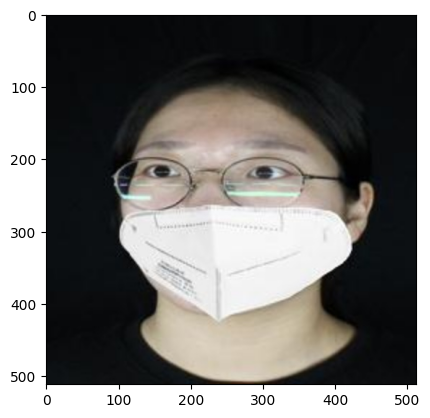

In [62]:
img = plt.imread(img_path)
plt.imshow(img)

In [51]:
img_path = '/content/drive/MyDrive/processed/masked_image/0001_0001.png.jpg'
img_size = 256
img = plt.imread(img_path)
if img_path.endswith('.jpg') or img_path.endswith('.PNG'):
    img = img * 255.0
img = tf.keras.preprocessing.image.img_to_array(img)
img = tf.image.resize(img, [img_size, img_size],
                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
img = tf.reshape(img, [1, img_size, img_size, 3])
img = tf.cast(img, tf.float32)
img =  (img / 127.5) - 1
img

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[13., 15., 19.],
         [13., 15., 19.],
         [13., 15., 19.],
         ...,
         [17., 19., 23.],
         [17., 19., 23.],
         [17., 19., 23.]],

        [[13., 15., 19.],
         [13., 15., 19.],
         [13., 15., 19.],
         ...,
         [17., 19., 23.],
         [17., 19., 23.],
         [17., 19., 23.]],

        [[13., 15., 19.],
         [13., 15., 19.],
         [13., 15., 19.],
         ...,
         [17., 19., 23.],
         [17., 19., 23.],
         [17., 19., 23.]],

        ...,

        [[25., 33., 39.],
         [25., 33., 39.],
         [25., 33., 39.],
         ...,
         [21., 23., 27.],
         [21., 23., 27.],
         [21., 23., 27.]],

        [[25., 33., 39.],
         [25., 33., 39.],
         [25., 33., 39.],
         ...,
         [21., 23., 27.],
         [21., 23., 27.],
         [21., 23., 27.]],

        [[25., 33., 39.],
         [25., 33., 39.],
         [25., 3

In [99]:
def test_image(image_file):
        """
        test image load
        """
        # Read and decode an image file to a uint8 tensor
        image = tf.io.read_file(image_file)
        image = tf.io.decode_image(image, channels=3, expand_animations = False)

        input_image = image[:, :, :]

        # Convert both images to float32 tensors
        input_image = tf.cast(input_image, tf.float32)
        return input_image

def test_resize_and_normalize(mask_image, height, width):
      """
      image resize and [-1 ~ 1] normalize
      """
      input_image = tf.image.resize(mask_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
      input_image = tf.cast(input_image, tf.float32)
      input_image = (input_image / 127.5) - 1
      return input_image

def load_image_test(image_file):
        input_image = test_image(image_file)
        input_image = test_resize_and_normalize(input_image, img_size, img_size)
        return input_image

def make_test(image_file):
        dataset = tf.data.Dataset.list_files(image_file, shuffle=False)
        dataset = dataset.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        return dataset

In [101]:
load_image_test('/content/drive/MyDrive/processed/masked_image/0001_0001.png.jpg')

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        ...,
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236]],

       [[-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        ...,
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236]],

       [[-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        [-0.94509804, -0.9372549 , -0.92156863],
        ...,
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236],
        [-0.92941177, -0.92156863, -0.90588236]],

       ...,

     

In [70]:
image = tf.io.read_file('/content/drive/MyDrive/processed/masked_image/0001_0001.png.jpg')
image = tf.io.decode_image(image, channels=3, expand_animations = False)

input_image = image[:, :, :]

# Convert both images to float32 tensors
input_image = tf.cast(input_image, tf.float32)
input_image

<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
array([[[ 7.,  8., 10.],
        [ 7.,  8., 10.],
        [ 7.,  8., 10.],
        ...,
        [ 9., 10., 12.],
        [ 9., 10., 12.],
        [ 9., 10., 12.]],

       [[ 7.,  8., 10.],
        [ 7.,  8., 10.],
        [ 7.,  8., 10.],
        ...,
        [ 9., 10., 12.],
        [ 9., 10., 12.],
        [ 9., 10., 12.]],

       [[ 7.,  8., 10.],
        [ 7.,  8., 10.],
        [ 7.,  8., 10.],
        ...,
        [ 9., 10., 12.],
        [ 9., 10., 12.],
        [ 9., 10., 12.]],

       ...,

       [[13., 17., 20.],
        [13., 17., 20.],
        [13., 17., 20.],
        ...,
        [10., 11., 13.],
        [10., 11., 13.],
        [11., 12., 14.]],

       [[13., 17., 20.],
        [13., 17., 20.],
        [13., 17., 20.],
        ...,
        [10., 11., 13.],
        [10., 11., 13.],
        [11., 12., 14.]],

       [[13., 17., 20.],
        [13., 17., 20.],
        [13., 17., 20.],
        ...,
        [10., 11., 

In [71]:
input_image = tf.image.resize(input_image, [256, 256],
                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
input_image = tf.cast(input_image, tf.float32)
input_image = tf.reshape(input_image, [1, img_size, img_size, 3])
input_image = (input_image / 127.5) - 1
input_image

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         ...,
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.90588236]],

        [[-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         ...,
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.90588236]],

        [[-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         [-0.94509804, -0.9372549 , -0.92156863],
         ...,
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.90588236],
         [-0.92941177, -0.92156863, -0.9058823

In [75]:
class Mask_G(tf.keras.Model):
    def __init__(self, filters=32, block_num=5):
        super(Mask_G, self).__init__()
        self.filters = filters
        self.block_num = block_num
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.encoders = []
        self.decoders = []

    def build(self, input_shape):

        # Encoder layers
        for i in range(self.block_num):
            norm_type = 'instance' if i != 0 else None
            downsample_block = conv_block(self.filters, size=3, strides=2,
                                          norm_type=norm_type, activation='lrelu')

            self.encoders.append(downsample_block)

            self.filters = self.filters*2 if i < 4 else self.filters

        self.encoders.append(conv_block(self.filters, size=3, strides=2,
                                        norm_type='instance', activation='lrelu'))
        # Dencoder layers
        for i in range(self.block_num):
            self.decoders.append(conv_block(self.filters, size=3, strides=2,
                                            norm_type='instance', activation='relu',
                                            downsample=False))
            self.filters//=2

        self.out = layers.Conv2DTranspose(1,
                                          kernel_size=3,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=self.initializer,
                                          use_bias=False)

    def call(self, inputs, training=False):
        x = inputs

        encoders_outputs = []
        for i, block in enumerate(self.encoders):
            x = block(x)

            print(f"Encoder {i} output shape: {x.shape}")

            if 0 < i < self.block_num:
                encoders_outputs.append(x)
        for i, block in enumerate(self.decoders):
            x = block(x)
            if i < self.block_num-1:
                x = tf.concat([encoders_outputs.pop(), x], -1)
        out = self.out(x)

        return tf.keras.activations.tanh(out)

In [110]:
mask_G, face_G = Mask_G(filters=32), Face_G(filters=32)

In [116]:
mask = mask_G(input_image, training=False)
mask

<tf.Tensor: shape=(1, 256, 256, 1), dtype=float32, numpy=
array([[[[-0.01537825],
         [-0.01306965],
         [-0.07923559],
         ...,
         [-0.01951551],
         [-0.07166731],
         [ 0.01955782]],

        [[ 0.01874872],
         [ 0.00721267],
         [ 0.06881507],
         ...,
         [ 0.07128934],
         [ 0.06031942],
         [ 0.03168278]],

        [[ 0.00316601],
         [ 0.02603783],
         [-0.0904079 ],
         ...,
         [-0.05964373],
         [-0.04655335],
         [-0.00054817]],

        ...,

        [[ 0.01108528],
         [ 0.01373102],
         [ 0.12103666],
         ...,
         [ 0.04194229],
         [ 0.05294433],
         [ 0.01826423]],

        [[-0.0478344 ],
         [-0.02174154],
         [-0.15287243],
         ...,
         [ 0.02797836],
         [-0.14472884],
         [ 0.00190425]],

        [[ 0.01545244],
         [ 0.03253838],
         [ 0.04335034],
         ...,
         [ 0.07076395],
         [-0.01483

<function matplotlib.pyplot.show(close=None, block=None)>

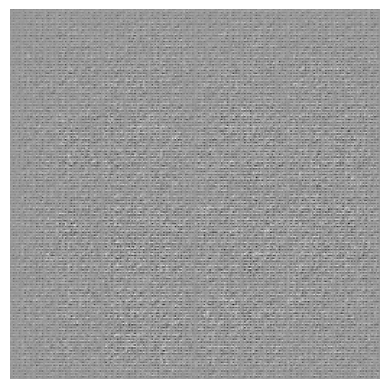

In [121]:
image = mask[0, :, :, :].numpy()

# 만약 텐서의 값 범위가 [-1, 1]이라면, [0, 1] 범위로 조정
if image.min() < 0:
    image = (image + 1) / 2

# 이미지 출력
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show

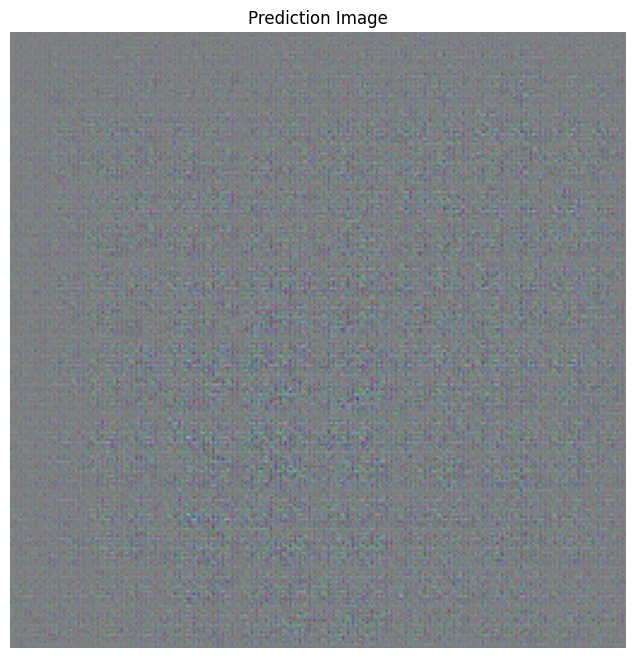

In [112]:
mask = noise_processing(mask)
pred = face_G([input_image, mask], training=False)

plt.figure(figsize=(8,8))
plt.title('Prediction Image')
plt.imshow(pred[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()